# Predicting Loan Defaults w/ Natural Language Processing (NLP) #
## 4.1 Term Frequency (TF) Modelling ##

Created on Tues Feb 12 20:30:12 2019

@author: Greenwood Group

## STEP 4: Term Frequency (TF) Modelling ##

### 4.1 Import required libraries ###

In [2]:
# System libraries
import os
import sys
import time
import warnings

# Basic Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re # regular expressions library
import string
import spacy
import nltk # natural language toolkit library
import unidecode
import enchant
import gensim
import random

from nltk.corpus import stopwords # stopwords library
from nltk.stem import WordNetLemmatizer # lemmatization library
from textblob import TextBlob, Word
from bs4 import BeautifulSoup
from googletrans import Translator
from yellowbrick.text import FreqDistVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#nltk.download('stopwords') # download the stop words library
#nltk.download('all') # to download the complete nltk library
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

# ### Turn off Depreciation and Future warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
% matplotlib inline

pd.set_option('precision', 3) # set the precision of numerical representation
pd.set_option('expand_frame_repr', True)

### 4.2 Prepare for reproducability ###

In [3]:
# Set random seed to maintain reproducability
random_state = np.random.seed(42)

# Set the plotting style
plt.style.use('seaborn-whitegrid')

sns.set(style="whitegrid", palette="PRGn", color_codes=True, font='sans-serif', font_scale=1.5)

### 4.3 Import data ###

In [4]:
# Import the dataset
# Set the path to data
filename = '../data/processed/4.0-gg-processed-text-data.csv'

# Read the data into memory
%time df = pd.read_csv(filename, keep_default_na=False)

CPU times: user 111 ms, sys: 21.9 ms, total: 133 ms
Wall time: 132 ms


In [5]:
df.head(5)

,loan_amount,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,sector_Food,sector_Health,sector_Housing,...,gender_F,nonpayment_lender,description,status,word_count,char_count,avg_word,stopwords,numerics,normalized_en
0,500.0,1,0,0,0,0,0,0,0,0,...,0,1,<i>This description is written by Rowland Amul...,0,150,897,4.940,59,3,addition brother plant vegetable diversify tea...
1,500.0,0,0,0,0,0,0,1,0,0,...,1,1,<i>This description is written by Rowland Amul...,0,223,1279,4.838,84,0,responsible without parent die leave twin sist...
2,500.0,0,0,0,0,0,0,1,0,0,...,0,1,<i>This description was written by Richard Maz...,0,155,897,4.841,59,3,attend elementary little acre vegetable maize ...
3,500.0,0,0,0,0,0,0,0,0,0,...,1,1,<i>This description was written by Rowland Amu...,0,121,737,4.959,44,2,girl addition parent parent lose job long rema...
4,500.0,0,0,0,1,0,0,0,0,0,...,0,1,<i>This description was written by Rowland Amu...,0,145,798,4.614,51,6,brother church pastor responsibility orphan dr...


In [6]:
# The number of "features" (i.e., tokens) we want to keep in the BOW.
%time no_features = 1000
#%time no_features = max(df['normalized_en'].apply(lambda text: len(nltk.word_tokenize(text))))

print("\nNumber of features: {}".format(no_features))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs

Number of features: 1000


### 4.4 Topic Modeling with Sci-kit Learn ###

In [7]:
tf_vectorizer = CountVectorizer(min_df=0.01, 
                                max_features=no_features,
                                ngram_range=[1,5])
%time dtm_tf = tf_vectorizer.fit_transform(df['normalized_en'])
print("\n", dtm_tf.shape)

CPU times: user 3.43 s, sys: 193 ms, total: 3.62 s
Wall time: 3.72 s

 (7988, 1000)


### 4.5 Visualize frequency distribution of top n tokens ###

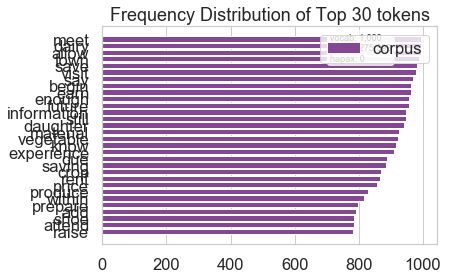

In [8]:
feature_names = tf_vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=feature_names, n=30)
visualizer.fit(dtm_tf)
visualizer.poof()

In [9]:
%time df['normalized_en_tf'] = df['normalized_en'].apply(lambda x: [word for word in x.split() if word in feature_names])

CPU times: user 1.97 s, sys: 3.73 ms, total: 1.97 s
Wall time: 1.97 s


In [10]:
df['normalized_en_tf'].head(5)

0    [addition, brother, plant, vegetable, diversif...
1    [responsible, without, parent, die, leave, sis...
2    [attend, little, vegetable, maize, decide, ani...
3    [girl, addition, parent, parent, lose, job, lo...
4    [brother, church, responsibility, orphan, drop...
Name: normalized_en_tf, dtype: object

### 4.6 Bag of Words (BoW) modelling ###

In [11]:
# inspired by https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb
# Set up a dictionary of words
dictionary = gensim.corpora.Dictionary(df['normalized_en_tf'])

# Get the length of dictionary
len(dictionary)

688

In [12]:
# Filter out the top 1000 words that appear in at least 20 documents
dictionary.filter_extremes(no_below = 20, keep_n = 1000)

# Get the length of the dictionary
print(len(dictionary))

688


In [13]:
# Convert the dictionary into a tuple which maps the word to the number of counts
bow_corpus = [dictionary.doc2bow(desc) for desc in df['normalized_en_tf']]

### 4.7 Run LDA with TF (BoW) ###

In [14]:
# Define the LDA model with the BoW corpus
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                      num_topics=15,
                                      alpha='asymmetric',
                                      eta='auto', # priori belief on word probability
                                      id2word=dictionary,
                                      minimum_probability=0.20,
                                      passes=20,
                                      iterations=500,
                                      random_state=random_state)

In [15]:
# Print out each topic
topics = {}

for index, topic in lda_model.print_topics(-1):
    topics[index] = re.findall('\"(\w+)"', topic)
    
for topic in topics:
    print("Topic: {} \n{}".format(topic, topics[topic]))
    print("")

Topic: 0 
['share', 'thank', 'back', 'solidarity', 'micro', 'behalf', 'together', 'person', 'bread', 'lending']

Topic: 1 
['dairy', 'maize', 'active', 'per', 'primary', 'cereal', 'bean', 'farming', 'apply', 'vegetable']

Topic: 2 
['dream', 'college', 'hand', 'future', 'opportunity', 'feel', 'come', 'could', 'change', 'ready']

Topic: 3 
['visit', 'org', 'www', 'educational', 'information', 'microfinance', 'please', 'mifex', 'microinsurance', 'salon']

Topic: 4 
['must', 'season', 'rainy', 'interest', 'rate', 'cattle', 'often', 'crop', 'shark', 'form']

Topic: 5 
['fruit', 'vegetable', 'charcoal', 'chicken', 'raise', 'additional', 'fund', 'animal', 'stand', 'include']

Topic: 6 
['su', 'la', 'que', 'en', 'el', 'negocio', 'para', 'tiene', 'con', 'aos']

Topic: 7 
['merchandise', 'begin', 'cement', 'goal', 'fish', 'door', 'cosmetic', 'volunteer', 'save', 'price']

Topic: 8 
['machine', 'material', 'within', 'tailor', 'rent', 'employ', 'period', 'sister', 'saving', 'therefore']

Topic: 9

In [16]:
# Get the count of each word in the topic
word_dict = {}
for index in topics:
    for word in topics[index]:  
        if (word in word_dict.keys()):
            word_dict[word] = word_dict[word] + 1
        else:
            word_dict[word] = 1

# Show the sorted word dictionary for the topics
dict(sorted(word_dict.items(), key=lambda x: x[1]))

{'share': 1,
 'thank': 1,
 'back': 1,
 'solidarity': 1,
 'behalf': 1,
 'together': 1,
 'person': 1,
 'bread': 1,
 'lending': 1,
 'dairy': 1,
 'maize': 1,
 'per': 1,
 'cereal': 1,
 'bean': 1,
 'farming': 1,
 'apply': 1,
 'dream': 1,
 'college': 1,
 'hand': 1,
 'future': 1,
 'opportunity': 1,
 'feel': 1,
 'come': 1,
 'could': 1,
 'change': 1,
 'ready': 1,
 'visit': 1,
 'org': 1,
 'www': 1,
 'educational': 1,
 'information': 1,
 'microfinance': 1,
 'please': 1,
 'mifex': 1,
 'microinsurance': 1,
 'must': 1,
 'rainy': 1,
 'interest': 1,
 'rate': 1,
 'cattle': 1,
 'shark': 1,
 'fruit': 1,
 'charcoal': 1,
 'chicken': 1,
 'raise': 1,
 'additional': 1,
 'fund': 1,
 'animal': 1,
 'stand': 1,
 'include': 1,
 'su': 1,
 'la': 1,
 'que': 1,
 'en': 1,
 'el': 1,
 'negocio': 1,
 'para': 1,
 'tiene': 1,
 'con': 1,
 'aos': 1,
 'merchandise': 1,
 'cement': 1,
 'goal': 1,
 'fish': 1,
 'door': 1,
 'cosmetic': 1,
 'volunteer': 1,
 'save': 1,
 'price': 1,
 'machine': 1,
 'material': 1,
 'within': 1,
 'tailor

### 4.8 Model evaluation ###

In [17]:
# Select a random line to evaluate (Use same line throughout all steps below)
# Good example = 3597
#line = random.randint(0, len(df))

line=3597
#line=5490 # contains spanish
#line = 4536

print("Instance number:", line)

print("\nOriginal Text: \n", df["description"][line])

print("\nNormalized Text: \n", df["normalized_en"][line])

Instance number: 3597

Original Text: 
 <p class="MsoNormal"><span>Diana Farias, who was born in </span><a href="http://en.wikipedia.org/wiki/Quevedo,_Ecuador" target="_blank" title="Quevado"><span>Quevado</span></a><span>, </span><span>Ecuador</span><span>, is a 22 year-old single woman who resides with her parents. She runs a small gift shop in the Municipal de Bastin Popular that is known for its selection of perfumes. She has been in business for 5 years. Every morning from </span><span>6:00 am</span><span> until </span><span>2:00 pm</span><span> Diana and her mother operate their shop. Ms. Farias wants this loan to buy more products and diversify her stock. This hard-working young woman not only runs this business; she is wrapping up her studies at the University in Business Administration. </span></p>

Normalized Text: 
 bear reside parent gift know selection perfume morning pm diversify working wrap study


### 4.9 Evaluate LDA Term Frequency model ###

In [18]:
for index, score in sorted(lda_model[bow_corpus[line]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nIndex: {} \nTopic: {}".format(score*100, index, topics[index]))


Score: 91.39783978462219	 
Index: 7 
Topic: ['merchandise', 'begin', 'cement', 'goal', 'fish', 'door', 'cosmetic', 'volunteer', 'save', 'price']


### 4.10 Clean up the dataset in preparation for modelling ###

In [19]:
# Re-order all the columns in the dataframe - put status first
columnsTitles = ['status', 
                 'loan_amount', 
                 'sector_Agriculture', 
                 'sector_Arts', 
                 'sector_Clothing', 
                 'sector_Construction', 
                 'sector_Education', 
                 'sector_Entertainment', 
                 'sector_Food', 
                 'sector_Health', 
                 'sector_Housing', 
                 'sector_Manufacturing',  
                 'sector_Retail', 
                 'sector_Services', 
                 'sector_Transportation', 
                 'sector_Wholesale', 
                 'country_Ecuador', 
                 'country_Kenya', 
                 'gender_F', 
                 'nonpayment_lender', 
                 'normalized_en_tf'
                ]

%time df = df.reindex(columns=columnsTitles)

print("\n")
print(df.columns.values)

CPU times: user 7.14 ms, sys: 5.93 ms, total: 13.1 ms
Wall time: 12.2 ms


['status' 'loan_amount' 'sector_Agriculture' 'sector_Arts'
 'sector_Clothing' 'sector_Construction' 'sector_Education'
 'sector_Entertainment' 'sector_Food' 'sector_Health' 'sector_Housing'
 'sector_Manufacturing' 'sector_Retail' 'sector_Services'
 'sector_Transportation' 'sector_Wholesale' 'country_Ecuador'
 'country_Kenya' 'gender_F' 'nonpayment_lender' 'normalized_en_tf']


In [20]:
# Add Topics to data frame - MORE WORK HERE
%time df_topics = pd.DataFrame.from_dict(topics, orient='index')
df_topics

CPU times: user 2.15 ms, sys: 523 µs, total: 2.67 ms
Wall time: 2.38 ms


,0,1,2,3,4,5,6,7,8,9
0,share,thank,back,solidarity,micro,behalf,together,person,bread,lending
1,dairy,maize,active,per,primary,cereal,bean,farming,apply,vegetable
2,dream,college,hand,future,opportunity,feel,come,could,change,ready
3,visit,org,www,educational,information,microfinance,please,mifex,microinsurance,salon
4,must,season,rainy,interest,rate,cattle,often,crop,shark,form
5,fruit,vegetable,charcoal,chicken,raise,additional,fund,animal,stand,include
6,su,la,que,en,el,negocio,para,tiene,con,aos
7,merchandise,begin,cement,goal,fish,door,cosmetic,volunteer,save,price
8,machine,material,within,tailor,rent,employ,period,sister,saving,therefore
9,production,crop,fertilizer,produce,harvest,seed,wood,season,quality,type


In [21]:
%time dtm_tf_arr = dtm_tf.toarray()

CPU times: user 16.5 ms, sys: 21.9 ms, total: 38.4 ms
Wall time: 36.4 ms


In [22]:
%time df_bow = pd.DataFrame(list(map(np.ravel, dtm_tf_arr)))

df_bow.head(1)

CPU times: user 19.2 s, sys: 300 ms, total: 19.5 s
Wall time: 19.7 s


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
%time df_tf = df.join(df_bow)

print("\n")
df_tf.head(1)

CPU times: user 32.7 ms, sys: 25 ms, total: 57.7 ms
Wall time: 56.9 ms




,status,loan_amount,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,sector_Food,sector_Health,...,990,991,992,993,994,995,996,997,998,999
0,0,500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_tf = df_tf.drop(['normalized_en_tf'], axis = 1)

#print(df_final.columns.values)

print(df_tf.head(1).T)

                           0
status                   0.0
loan_amount            500.0
sector_Agriculture       1.0
sector_Arts              0.0
sector_Clothing          0.0
sector_Construction      0.0
sector_Education         0.0
sector_Entertainment     0.0
sector_Food              0.0
sector_Health            0.0
sector_Housing           0.0
sector_Manufacturing     0.0
sector_Retail            0.0
sector_Services          0.0
sector_Transportation    0.0
sector_Wholesale         0.0
country_Ecuador          0.0
country_Kenya            1.0
gender_F                 0.0
nonpayment_lender        1.0
0                        0.0
1                        0.0
2                        0.0
3                        0.0
4                        1.0
5                        0.0
6                        1.0
7                        0.0
8                        0.0
9                        0.0
...                      ...
970                      0.0
971                      0.0
972           

In [25]:
# Columns of the raw data
print(df_tf.columns.values)
print("\n")
print(df_tf.head(1).T)

['status' 'loan_amount' 'sector_Agriculture' ... 997 998 999]


                           0
status                   0.0
loan_amount            500.0
sector_Agriculture       1.0
sector_Arts              0.0
sector_Clothing          0.0
sector_Construction      0.0
sector_Education         0.0
sector_Entertainment     0.0
sector_Food              0.0
sector_Health            0.0
sector_Housing           0.0
sector_Manufacturing     0.0
sector_Retail            0.0
sector_Services          0.0
sector_Transportation    0.0
sector_Wholesale         0.0
country_Ecuador          0.0
country_Kenya            1.0
gender_F                 0.0
nonpayment_lender        1.0
0                        0.0
1                        0.0
2                        0.0
3                        0.0
4                        1.0
5                        0.0
6                        1.0
7                        0.0
8                        0.0
9                        0.0
...                      ...
970     

### 4.11 Save processed text file ###

In [26]:
# save the updated dataframe back
df_tf.to_csv('../data/processed/4.1-gg-processed-text-data-tf-model.csv', index=False)